# Vienasluoksniai tinklai

Mašininio mokymosi ir giliojo mokymosi srityse dažnai susiduriama su dviejų rūšių problemomis - regresija ir klasifikacija. Regresijos uždaviniuose prognozuojate funkcijos reikšmes, o klasifikavimo uždaviniuose prognozuojate skirtingas objektų klases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

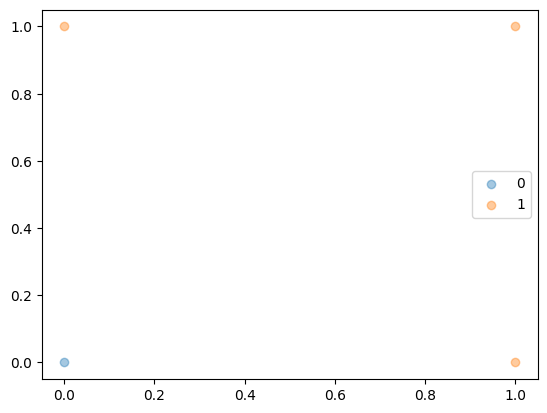

In [2]:
n_samples = 1000

X0 = np.random.normal(loc=[-1,4], scale=[1,0.5], size=(int(n_samples/2), 2))
X1 = np.random.normal(loc=[2,4], scale=[0.5,2], size=(int(n_samples/2), 2))
y0 = np.zeros((int(n_samples/2),1))
y1 = np.ones((int(n_samples/2),1))
X = np.vstack([X0, X1])
yhat = np.vstack([y0, y1])

X = np.array([[0,0],[0,1],[1,0],[1,1]])
yhat = np.array([[0],[1],[1],[1]])

plt.scatter(*X[yhat[:,0]==0].T, label='0', alpha=0.4); 
plt.scatter(*X[yhat[:,0]==1].T, label='1', alpha=0.4);
plt.legend();

Naudosime sigmoidinę aktyvacijos funkciją:

$$ f(z) = \frac{1}{1+e^{-z}} $$

$$ \frac{\mathrm{d}f}{\mathrm{d}z} = f(z) \cdot (1-f(z)) $$

In [3]:
def f(z):
    return 1 / (1 + np.exp(-z))

def dfdz(z):
    return f(z) * (1 - f(z))

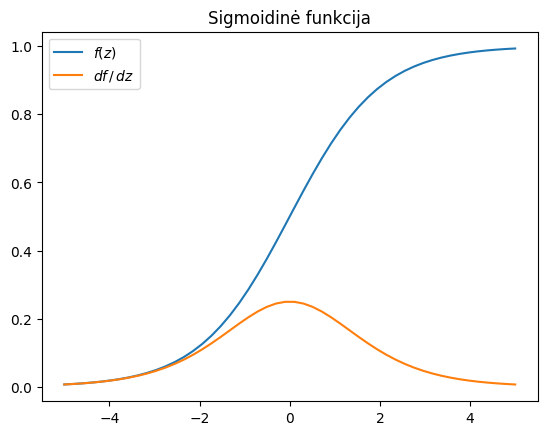

In [4]:
z = np.linspace(-5,5)
plt.plot(z, f(z), label='$f(z)$'); 
plt.plot(z, dfdz(z), label='$df\, /\,dz$'); 
plt.legend();
plt.title('Sigmoidinė funkcija');

## Tinklo struktūra

Neuronas susijęs su įvesties duomenų masyvu $x_i$ per svorio vektorių $w_i$. Atliekame skaliarinę $w$ ir $x$ sandaugą ir pritaikius šiam skaičiui aktyvacijos funkciją $f$, gauname neurono išvestį $y$:

$$ \mathrm{output} = f(w \cdot x + b) \equiv f(z) $$
čia apibrėžiame, kad $z = w\cdot x$+b.

Jei turime daug sluoksnių, ši išvestis perduodama kaip įvestis kitam neuronų sluoksniui. Šiame pavyzdyje naudosime sigmoidinę funkciją. 

Mūsų neuroninis tinklas turės tik vieną išvestį - $y$. Išvesties reikšmė yra tarp 0 ir 1, nes tai yra sigmoidinės funkcijos rezultatas. Tikrosios reikšmės bus žymimos $\hat y$.

* Išvestis: $y$, $0<y<1$
* Tikroji reikšmė: $\hat y$ (1 arba 0)

## Nuostolių funkcija

Neuroninio tinklo apmokymo metu minimizuosime kryžminės entropijos nuostolių funkciją:

$$ J(y, \hat y) = −(\hat y\log(y) + (1−\hat y)\log(1−y)) $$

$$ \frac{\partial J}{\partial y} = \frac{1-\hat y}{1-y} -\frac{\hat y}{y} $$

Atkreipkite dėmesį į tai, kad čia skaičiuojamas neuroninio tinklo išvesties logaritmas bei dalyba iš jo. Tikėtina, kad ši reikšmė bus lygi arba artimos 0 arba 1 reikšmėms. Jei priartėsime prie dalybos iš 0 arba logaritmo iš 0, mūsų algoritme gali atsirasti skaitiniai nestabilumai. Dėl šios priežasties, pridedame nedidelę konstantą `eps`.

In [5]:
def J(y, yhat):
    eps = 1e-8
    return -(yhat * np.log(y+eps) + (1-yhat) * np.log(1-y+eps))

def dJdy(y, yhat):
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)

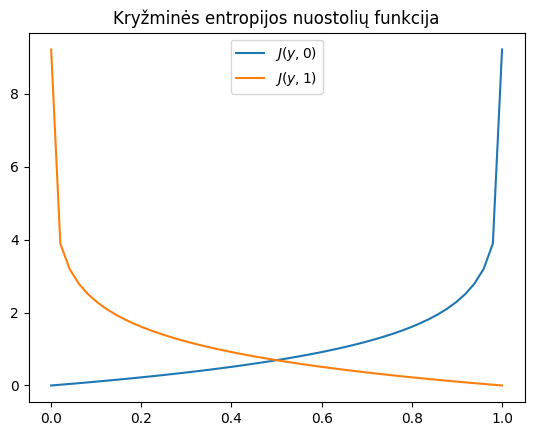

In [6]:
y = np.linspace(0.0001,0.9999)
plt.plot(y, J(y,0), label='$J(y,0)$'); 
plt.plot(y, J(y,1), label='$J(y,1)$'); 
plt.legend();
plt.title('Kryžminės entropijos nuostolių funkcija');

## Prognozavimas

* Įvestis $x_i$ ($i=0,...,n$)
* Svoriai $w_{i}$ ($i=0,...,n$) ir $b$
* Išvestis $y$

$$y = f\left(\sum_i w_i x_i + b\right) = f(w \cdot x + b)$$

Išvesties skaičiavimas atliekant prognozę pagal įėjimų ir svorių rinkinį vadinamas tiesioginės sklaidos perdavimu.

In [1259]:
def forward(x, w, b):
    return f(np.matmul(x,w)+b)

## Tinklo apmokymas

Norėdami išsiaiškinti, kokie turėtų būti svoriai, juos atnaujinsime stochastinio gradientinio nusileidimo metodu (po vieną žingsnį kiekvienam duomenų rinkinio elementui) naudodami kryžminės entropijos nuostolių funkciją. Šiuo atveju, reikia judėti priešinga gradiento kryptimi žemyn kiekvieno svorio $w_i$ ir $b$ kryptimis, darydami $\alpha$ dydžio žingsnius. Atnaujinimo taisyklė atrodo taip:

$$ w_i \rightarrow w_i - \alpha \frac{\partial J}{\partial w_i}$$

\begin{align*}
\frac{\partial J}{\partial w_i} &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial w_i}\\
 &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial z} \frac{ \partial z(w,x)}{\partial w_i} 
\end{align*}


Kadangi $z = \sum x_i w_i+b$, gauname $\partial z / \partial w_i = x_i$. Taip pat, $y(z) = f(z)$. Gauname:


\begin{align*}
\frac{\partial J}{\partial w_i} &= \left[\frac{1-\hat y}{1-y(z)} - \frac{\hat y}{y(z)} \right]\left[ y(z)(1-y(z)) \right]\left[ x_i \right]\\
&= \left(y(1-\hat y) - \hat y(1-y) \right)x_i
\end{align*}

Tuomet atnaujinimo taisyklė:

$$ w_i \rightarrow w_i - \alpha \left(y(1-\hat y) - \hat y(1-y) \right)x_i $$

In [1260]:
## Option one: use the given derivatives (clearer)
def backward1(x, w, b, y, yhat, alpha):
    z = np.dot(x, w)
    delta = dJdy(y, yhat) * dfdz(z) 
    
    dw = np.reshape(delta*x, (2, -1))
    db = delta
    
    w -= alpha*dw
    b -= alpha*db
    
    return w, b

## Option two: use the explicit calculted form (faster)
def backward2(x, w, b, y, yhat, alpha):  # w not needed for this form
    delta = ( y*(1-yhat) - yhat*(1-y) ) 
    
    dw = np.reshape(delta*x, (2, -1))
    db = delta
    
    w -= alpha*dw
    b -= alpha*db
    
    return w, b

def backward3(X, w, b, y, yhat, alpha):  # w not needed for this form
    delta = ( y*(1-yhat) - yhat*(1-y) ) 

    dw = np.reshape(np.mean(delta * X, axis=0), (2, -1))
    db = np.mean(delta)
    
    w -= alpha*dw
    b -= alpha*db
    
    return w, b

Neuroninio tinklo apmokymo eiga:

1. Kiekvienam imties elementui $x$ sudarome $y$ prognozę.
2. Apskaičiuojame svorių $w$ ir $b$ atnaujinimo žingsnius (atgalinis ėjimas) ir svorius atnaujiname

Keletą kartų pereiname per mokymo aibę, kiekvienam pavyzdžiui atlikdami nedidelius $w$ ir $b$ atnaujinimus. Kiekvienas atskiras pilnas ciklas kurio metu pilnai pereinama mokymo aibė vadinamas epocha.

In [1281]:
def train(X, yhat, n_epoch, alpha):
    costs = np.zeros(shape=(n_epoch,))

    np.random.seed(1)
    w = np.random.normal(0, 0.01, size=(X.shape[1],1)) 
    b = np.random.normal(0, 0.01)

    for epoch in range(n_epoch):
        
        #y = forward(X, w, b)
        #w, b = backward3(X, w, b, y, yhat, alpha)
        
        for i, x in enumerate(X):
            y = forward(x, w, b)  # prediction for one sample
            w, b = backward2(x, w, b, y, yhat[i], alpha)  # take step
            
        # Calculate total cost after epoch
        predictions = forward(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample

        # report progress
        if ((epoch % 10) == 0) or (epoch == (n_epoch - 1)):
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            
    return w, b, costs

Training accuracy after epoch 0: 75.0000%
Training accuracy after epoch 10: 75.0000%
Training accuracy after epoch 20: 75.0000%
Training accuracy after epoch 30: 75.0000%
Training accuracy after epoch 40: 100.0000%
Training accuracy after epoch 50: 100.0000%
Training accuracy after epoch 60: 100.0000%
Training accuracy after epoch 70: 100.0000%
Training accuracy after epoch 80: 100.0000%
Training accuracy after epoch 90: 100.0000%
Training accuracy after epoch 100: 100.0000%
Training accuracy after epoch 110: 100.0000%
Training accuracy after epoch 120: 100.0000%
Training accuracy after epoch 130: 100.0000%
Training accuracy after epoch 140: 100.0000%
Training accuracy after epoch 150: 100.0000%
Training accuracy after epoch 160: 100.0000%
Training accuracy after epoch 170: 100.0000%
Training accuracy after epoch 180: 100.0000%
Training accuracy after epoch 190: 100.0000%
Training accuracy after epoch 200: 100.0000%
Training accuracy after epoch 210: 100.0000%
Training accuracy after e

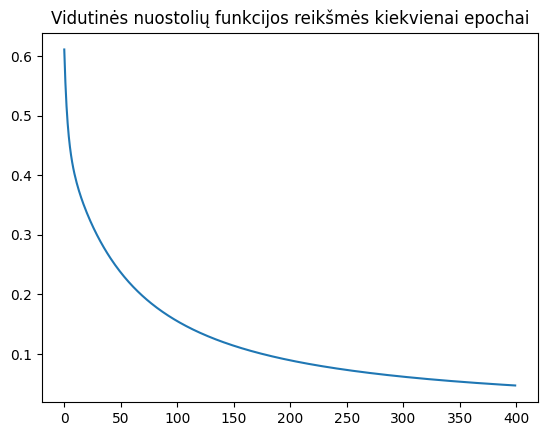

In [1285]:
w, b, costs = train(X, yhat, 400, 0.1)   

plt.plot(costs); 
plt.title('Vidutinės nuostolių funkcijos reikšmės kiekvienai epochai');

Kadangi dirbame 2D erdvėje, funkciją, kurią išmoko mūsų neuroninis tinklas, galime pavaizduoti grafike.

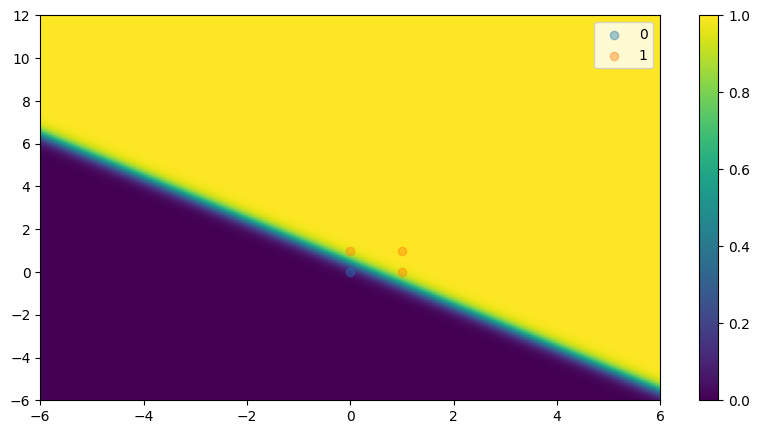

In [1286]:
x1 = np.linspace(-6,6,250)
x2 = np.flip(np.linspace(-6,12,250))

fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        val = forward([i,j], w, b)
        fun_map[m,n] = val

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(),x1.max(),x2.min(),x2.max()], vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X[yhat[:,0]==0].T, label='0', alpha=0.4); 
plt.scatter(*X[yhat[:,0]==1].T, label='1', alpha=0.4);
plt.legend();

## Netiesinė sprendimo riba

Matome, kad mūsų tinklo išmokta riba yra tik linija. Tai nestebina, nes iš esmės atliekame tik logistinę regresiją. Kas nutiks su sudėtingesniu duomenų rinkiniu?

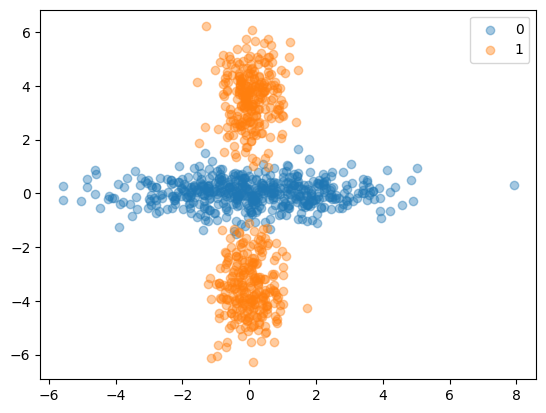

In [1278]:
n_samples = 1000
X0 = np.random.normal(loc=[0,0], scale=[2,0.5], size=(int(n_samples/2), 2))
X11 = np.random.normal(loc=[0,3.5], scale=[0.5,1], size=(int(n_samples/4), 2))
X12 = np.random.normal(loc=[0,-3.5], scale=[0.5,1], size=(int(n_samples/4), 2))
X1 = np.vstack([X11, X12])
y0 = np.zeros(shape=(int(n_samples/2), 1))
y1 = np.ones(shape=(int(n_samples/2), 1))
X = np.vstack([X0, X1])
yhat = np.vstack([y0, y1])

plt.scatter(*X[yhat[:,0]==0].T, label='0', alpha=0.4); 
plt.scatter(*X[yhat[:,0]==1].T, label='1', alpha=0.4);
plt.legend();

Training accuracy after epoch 0: 64.9000%
Training accuracy after epoch 10: 63.7000%
Training accuracy after epoch 20: 63.7000%
Training accuracy after epoch 30: 63.7000%
Training accuracy after epoch 40: 63.7000%
Training accuracy after epoch 50: 63.7000%
Training accuracy after epoch 60: 63.7000%
Training accuracy after epoch 70: 63.7000%
Training accuracy after epoch 80: 63.7000%
Training accuracy after epoch 90: 63.7000%
Training accuracy after epoch 100: 63.7000%
Training accuracy after epoch 110: 63.7000%
Training accuracy after epoch 120: 63.7000%
Training accuracy after epoch 130: 63.7000%
Training accuracy after epoch 140: 63.7000%
Training accuracy after epoch 150: 63.7000%
Training accuracy after epoch 160: 63.7000%
Training accuracy after epoch 170: 63.7000%
Training accuracy after epoch 180: 63.7000%
Training accuracy after epoch 190: 63.7000%
Training accuracy after epoch 200: 63.7000%
Training accuracy after epoch 210: 63.7000%
Training accuracy after epoch 220: 63.7000%

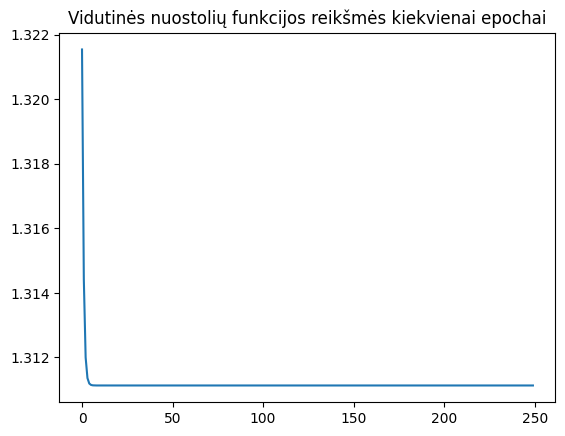

In [1282]:
w, b, costs = train(X, yhat, 250, 0.01)    

plt.plot(costs); 
plt.title('Vidutinės nuostolių funkcijos reikšmės kiekvienai epochai');

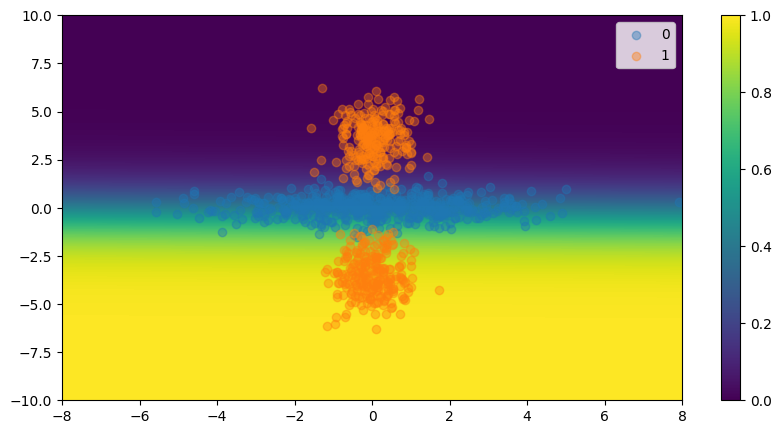

In [1283]:
x1 = np.linspace(-8,8,250)
x2 = np.flip(np.linspace(-10,10,250))
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forward([i,j], w, b)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(),x1.max(),x2.min(),x2.max()], vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X[yhat[:,0]==0].T, label='0', alpha=0.4); 
plt.scatter(*X[yhat[:,0]==1].T, label='1', alpha=0.4);
plt.legend()

Matome, kad rezultatai yra blogi (kartais net blogesni nei atsitiktinio spėjimo), o mokymas beveik iš karto sustoja. Be to, išmoktos funkcijos gradientas yra labai nedidelis. Tai galime suprasti kaip modelio netikrumą dėl to, ką ji turėtų išvesti.